In [1]:
import pandas as pd
import numpy as np
import nltk
import random
import time
import string
import collections
import matplotlib.pyplot as plt
import calendar
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from copy import copy, deepcopy
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pandas.tseries.offsets import *
from datetime import datetime
from calendar import monthrange
from dateutil import relativedelta
from datetime import datetime, timedelta
lmtzr=WordNetLemmatizer()

In [2]:
data_ads = "/Users/MaxTan/Documents/CU_16fall/BDA/Project/Data/"

user_raw = pd.read_csv(data_ads + "wow3_user2.csv", names = ["user_id", "review_count", "average_stars", 
                                               "friends", "fans", "votes_cool", "votes_funny", 
                                               "votes_useful", "num", "degree", "coefficient"])

business_raw = pd.read_csv(data_ads+"wow3_business_mysql.csv", names = ["business_id", "name", "latitude", 
                                                           "longitude", "stars", "categories", 
                                                           "review_count", "open"])

review_raw = pd.read_csv(data_ads+"wow3_review_mysql.csv", names = ["review_id", "user_id", "business_id", 
                                                       "stars", "text", "date", "votes_funny", 
                                                       "votes_useful"])

all_raw = pd.read_csv(data_ads+"wow3_all2.csv", names = ["business_id", 
                                                       "name", "stars_business","business_review_count",
                                                       "categories", "open", "review_id", 
                                                       "stars_review", "text", "date", "votes_funny", 
                                                       "votes_useful","user_id", "user_review_count", 
                                                       "average_stars","friends", "fans", "num", 
                                                       "degree", "coefficient"])


/Users/MaxTan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#3. Business Rate Prediction(Time Series):
#Input: a given business_id
#Output: predicted result of next month's rate and model data visualization

In [4]:
#Choose a business ID to create a sub-data-frame:
#temp_biz = collections.Counter(all_raw.business_id.values).most_common(10)[0][0]
temp_biz = "-Mh44q324VW8mpxIdH_HPw"

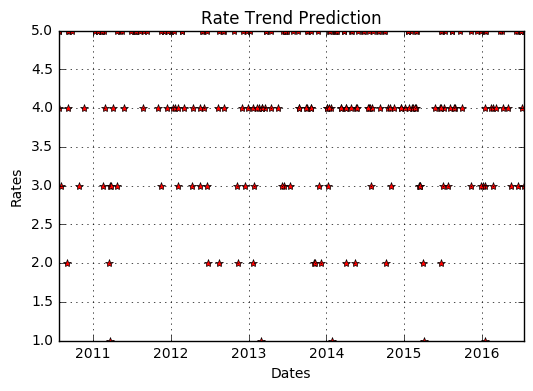

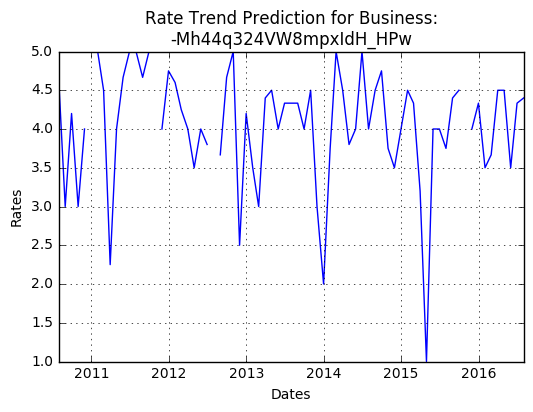

/Users/MaxTan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:63: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/Users/MaxTan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/Users/MaxTan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:71: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


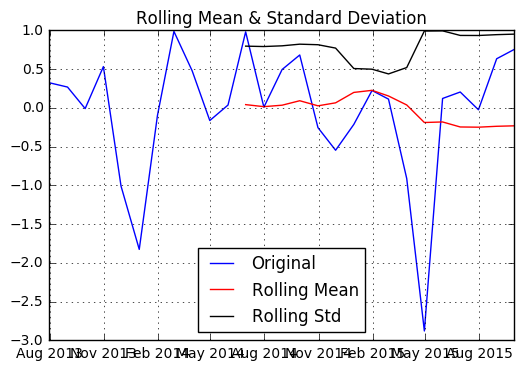

Results of Dickey-Fuller Test:
Test Statistic                 -3.636123
p-value                         0.005107
#Lags Used                      0.000000
Number of Observations Used    26.000000
Critical Value (5%)            -2.981247
Critical Value (1%)            -3.711212
Critical Value (10%)           -2.630095
dtype: float64


/Users/MaxTan/anaconda/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


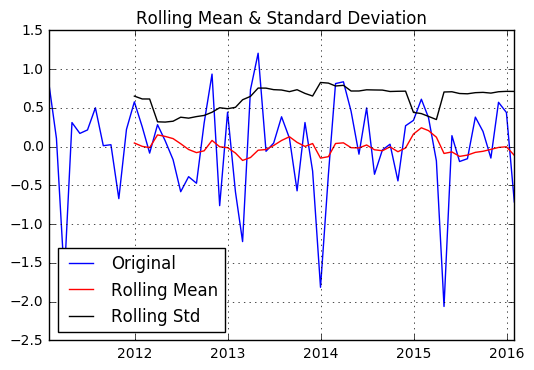

Results of Dickey-Fuller Test:
Test Statistic                 -5.362940
p-value                         0.000004
#Lags Used                      4.000000
Number of Observations Used    56.000000
Critical Value (5%)            -2.914731
Critical Value (1%)            -3.552928
Critical Value (10%)           -2.595137
dtype: float64


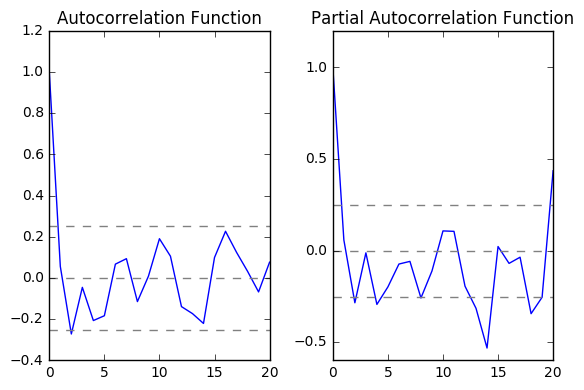

NameError: name 'res' is not defined

In [5]:
sub_biz = all_raw[all_raw['business_id']==temp_biz]

if sub_biz.shape[0]<200:
    raise ValueError('could not find enough review data for %s' % temp_biz)
sub_biz.head(1)


dates = [datetime.strptime(date,'%Y-%m-%d') for date in sub_biz.date.values]
rate_predict = pd.DataFrame()
rate_predict['rate'] = pd.Series(sub_biz.stars_review.values,index = pd.Series(dates))

plt.plot_date(x=rate_predict.index.values, y=rate_predict.rate.values,fmt='r*')
plt.title('Rate Trend Prediction')
plt.ylabel('Rates')
plt.xlabel('Dates')
plt.grid(True)
plt.show()
plt.close()


#Aggregation: group by month and take average
g = rate_predict.groupby(pd.TimeGrouper("M"))
rate_predict_avg = g.mean()
plt.plot_date(x=rate_predict_avg.index, y=rate_predict_avg.rate.values,fmt='b-')
plt.title('Rate Trend Prediction for Business:\n'+ temp_biz)
plt.ylabel('Rates')
plt.xlabel('Dates')
plt.grid(True)
plt.show()
plt.close()


#print rate_predict_avg.shape
if rate_predict_avg.shape[0]<36:
    raise ValueError('could not find enough review data for %s' % temp_biz)
    
    
    
start = rate_predict_avg.index[0]
end = rate_predict_avg.index[-1]


def calculate_monthdelta(date1, date2):
    def is_last_day_of_the_month(date):
        days_in_month = calendar.monthrange(date.year, date.month)[1]
        return date.day == days_in_month
    imaginary_day_2 = 31 if is_last_day_of_the_month(date2) else date2.day
    monthdelta = (
        (date2.month - date1.month) +
        (date2.year - date1.year) * 12 +
        (-1 if date1.day > imaginary_day_2 else 0)
        )
    return monthdelta

#print calculate_monthdelta(start,end)+1,rate_predict_avg.shape[0]




months = rate_predict_avg.shape[0]

#1.Rolling mean(Moving Average) of the monthly prediction:
moving_avg = pd.rolling_mean(rate_predict_avg,12)

rate_predict_moving_avg_diff = rate_predict_avg - moving_avg


def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries.values.ravel(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    
#Drop NA for Moving Average:
rate_predict_moving_avg_diff.dropna(inplace=True)
#Perform Stationarity Test:
test_stationarity(rate_predict_moving_avg_diff)


#3.Decomposition:

rate_predict_avg = rate_predict_avg.fillna(method = 'bfill')


decomposition = seasonal_decompose(rate_predict_avg)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

"""
plt.subplot(411)
plt.plot(rate_predict_avg, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
"""

rate_predict_decompose = residual
rate_predict_decompose.dropna(inplace=True)
test_stationarity(rate_predict_decompose)




lag_acf = acf(rate_predict_decompose, nlags=20)
lag_pacf = pacf(rate_predict_decompose, nlags=20, method='ols')


plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


model = ARIMA(rate_predict_avg, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  


plt.plot(rate_predict_decompose,color = 'green')
plt.plot(results_AR.fittedvalues, color = 'red')



plt.title('RSS: %.4f'% res)

plt.show()
plt.close()




predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)

predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()

predictions_AR = pd.Series(rate_predict_avg.values[0], index=rate_predict_avg.index)
predictions_AR = predictions_AR.add(predictions_AR_diff_cumsum,fill_value=0)


short_predict = results_AR.predict(start = months-6,end = months+6)

short_predict_AR_diff = pd.Series(short_predict, copy=True)

short_predict_AR_diff_cumsum = short_predict_AR_diff.cumsum()



short_predict_AR = pd.Series(rate_predict_avg[rate_predict_avg.index==short_predict.index[0]].rate.values[0], index=short_predict.index)
short_predict_AR = short_predict_AR.add(short_predict_AR_diff_cumsum,fill_value=0)



plt.plot(rate_predict_avg,color='green')

plt.plot(short_predict_AR,color = 'red')

res = 0.0
n = len(short_predict_AR.iloc[:6].values)
for i in range(n):
    res +=(short_predict_AR.iloc[:6].values[i]-rate_predict_avg.iloc[-6:].values[i])**2
res/=n
RMSE = np.sqrt(res[0])

plt.title('RMSE: %.4f'% RMSE)
plt.show()
plt.close()


print "The true data is "
print rate_predict_avg

print "The predicted data is"
print short_predict_AR

In [6]:
print results_AR.summary()

                             ARIMA Model Results                              
Dep. Variable:                 D.rate   No. Observations:                   72
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -95.281
Method:                       css-mle   S.D. of innovations              0.908
Date:                Wed, 21 Dec 2016   AIC                            196.562
Time:                        20:57:46   BIC                            203.392
Sample:                    08-31-2010   HQIC                           199.281
                         - 07-31-2016                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.0012      0.084      0.014      0.989        -0.163     0.165
ar.L1.D.rate    -0.2827      0.115     -2.465      0.016        -0.508    -0.058
                                    Roots   

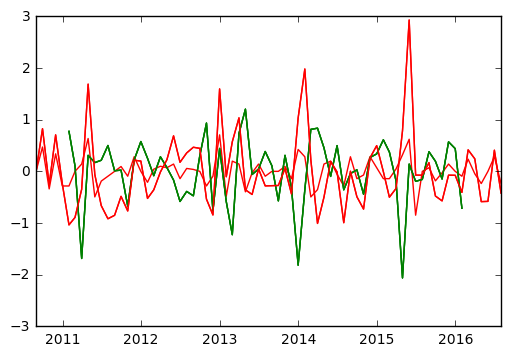

/Users/MaxTan/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


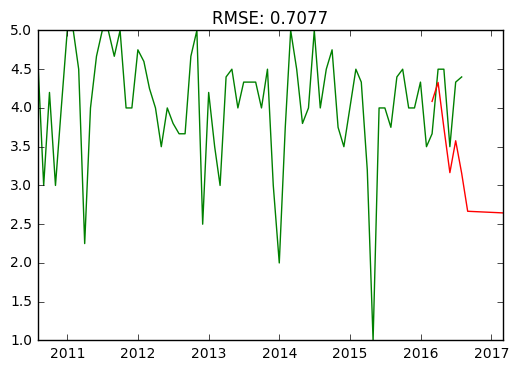

In [9]:
model = ARIMA(rate_predict_avg, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  

plt.plot(rate_predict_decompose,color = 'green')
plt.plot(results_MA.fittedvalues, color = 'red')



plt.show()
plt.close()




predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)

predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()

predictions_MA = pd.Series(rate_predict_avg.values[0], index=rate_predict_avg.index)
predictions_MA = predictions_MA.add(predictions_MA_diff_cumsum,fill_value=0)


short_predict = results_MA.predict(start = months-6,end = months+6)

short_predict_MA_diff = pd.Series(short_predict, copy=True)

short_predict_MA_diff_cumsum = short_predict_MA_diff.cumsum()


short_predict_MA = pd.Series(rate_predict_avg[rate_predict_avg.index==short_predict.index[0]].rate.values[0], index=short_predict.index)
short_predict_MA = short_predict_MA.add(short_predict_MA_diff_cumsum,fill_value=0)



plt.plot(rate_predict_avg,color='green')

plt.plot(short_predict_MA,color = 'red')

res = 0.0
n = len(short_predict_MA.iloc[:6].values)
for i in range(n):
    res +=(short_predict_MA.iloc[:6].values[i]-rate_predict_avg.iloc[-6:].values[i])**2
res/=n
RMSE = np.sqrt(res[0])

plt.title('RMSE: %.4f'% RMSE)
plt.show()
plt.close()

In [10]:
print results_MA.summary()

                             ARIMA Model Results                              
Dep. Variable:                 D.rate   No. Observations:                   72
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -82.278
Method:                       css-mle   S.D. of innovations              0.736
Date:                Wed, 21 Dec 2016   AIC                            170.556
Time:                        20:58:10   BIC                            177.386
Sample:                    08-31-2010   HQIC                           173.275
                         - 07-31-2016                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.0035      0.004     -0.860      0.393        -0.012     0.005
ma.L1.D.rate    -1.0000      0.040    -25.283      0.000        -1.078    -0.922
                                    Roots   

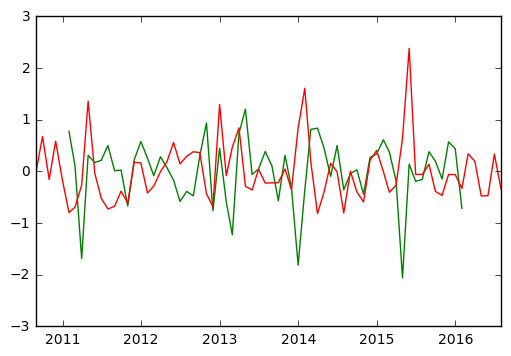

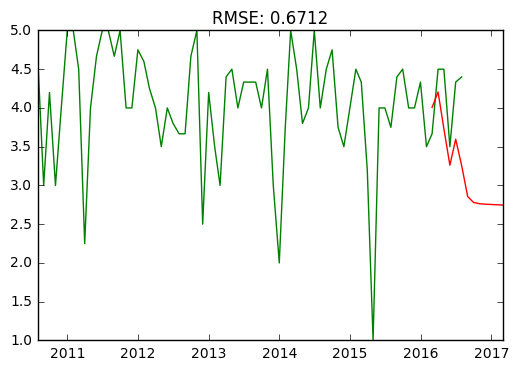

In [11]:
model = ARIMA(rate_predict_avg, order=(1, 1, 1))  

results_ARMA = model.fit(disp=-1)  


plt.plot(rate_predict_decompose,color = 'green')
plt.plot(results_ARMA.fittedvalues, color = 'red')




plt.show()
plt.close()




predictions_ARMA_diff = pd.Series(results_ARMA.fittedvalues, copy=True)

predictions_ARMA_diff_cumsum = predictions_ARMA_diff.cumsum()

predictions_ARMA = pd.Series(rate_predict_avg.values[0], index=rate_predict_avg.index)
predictions_ARMA = predictions_ARMA.add(predictions_ARMA_diff_cumsum,fill_value=0)


short_predict = results_ARMA.predict(start = months-6,end = months+6)

short_predict_ARMA_diff = pd.Series(short_predict, copy=True)

short_predict_ARMA_diff_cumsum = short_predict_ARMA_diff.cumsum()



short_predict_ARMA = pd.Series(rate_predict_avg[rate_predict_avg.index==short_predict.index[0]].rate.values[0], index=short_predict.index)
short_predict_ARMA = short_predict_ARMA.add(short_predict_ARMA_diff_cumsum,fill_value=0)



plt.plot(rate_predict_avg,color='green')

plt.plot(short_predict_ARMA,color = 'red')

res = 0.0
n = len(short_predict_ARMA.iloc[:6].values)
for i in range(n):
    res +=(short_predict_ARMA.iloc[:6].values[i]-rate_predict_avg.iloc[-6:].values[i])**2
res/=n
RMSE = np.sqrt(res[0])

plt.title('RMSE: %.4f'% RMSE)
plt.show()
plt.close()

In [12]:
print results_ARMA.summary()

                             ARIMA Model Results                              
Dep. Variable:                 D.rate   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -81.054
Method:                       css-mle   S.D. of innovations              0.726
Date:                Wed, 21 Dec 2016   AIC                            170.109
Time:                        20:58:17   BIC                            179.215
Sample:                    08-31-2010   HQIC                           173.734
                         - 07-31-2016                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.0035      0.005     -0.719      0.475        -0.013     0.006
ar.L1.D.rate     0.1843      0.117      1.572      0.120        -0.045     0.414
ma.L1.D.rate    -0.9999      0.038    -26.64